# NLP for Stock Market Prediction
Author: Antonio Stark, Sasha Pukhova, Frank Looi, Precious Enharo

Kaggle challenge: https://www.kaggle.com/aaron7sun/stocknews
Kaggle article: https://www.kaggle.com/rahulvarma9595/nlp-for-stock-market-predictions

## Import packages and libraries

In [1]:
# Import packages
import pandas as pd
import numpy as np
import string
import time
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, f1_score

## Import data

In [2]:
# import data
data = pd.read_csv('Combined_News_DJIA.csv')

print('data is %d data points with %d features'%(data.shape[0],data.shape[1]))
# data.head()

data is 1989 data points with 27 features


## Data preprocessing

In [3]:
## create copy of original dataframe
dataClean = data.copy()

# news header you want to test
## (2,5) is interesting to see how "Al-Qa'eda" gets transferred
## (4,3) is interesting to see how numbers are encoded
## (2,15) is interesting to see how both numbers ('55') and hyphens ('mega-city') are encoded
## (1988,24) gives a bug for replacing numbers and removing stop words
tester = (2,15)

for i in range(2,data.shape[1]):
    if i==tester[1]:
        print('Original text:')
        print(dataClean.iloc[tester[0],i])
    
    # Data cleaning
    
    ## remove 'b'' at the start and ''' at the end
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.strip("b'")
    if i==tester[1]:
        print('\nCleaned text:')
        print(dataClean.iloc[tester[0],i])
    
    ## remove punctuation
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.translate(str.maketrans('', '', string.punctuation))
    if i==tester[1]:
        print('\nPunctuations removed:')
        print(dataClean.iloc[tester[0],i])
        

    ## make lowercase
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.lower()
    if i==tester[1]:
        print('\nLowercase:')
        print(dataClean.iloc[tester[0],i])
    
    # remove numbers
    dataClean.iloc[:,i]=dataClean.iloc[:,i].str.translate(str.maketrans('', '', string.digits))
    if i==tester[1]:
        print('\nNumbers removed:')
        print(dataClean.iloc[tester[0],i])
    
#No need to do word tokenisation, stemming, lemmatization/ canonicalization in this model
# This is because words end up being broken down in the vectoriser
        

Original text:
b'55 pyramids as large as the Luxor stacked into a mega-city pyramid in Tokyo Bay'

Cleaned text:
55 pyramids as large as the Luxor stacked into a mega-city pyramid in Tokyo Bay

Punctuations removed:
55 pyramids as large as the Luxor stacked into a megacity pyramid in Tokyo Bay

Lowercase:
55 pyramids as large as the luxor stacked into a megacity pyramid in tokyo bay

Numbers removed:
 pyramids as large as the luxor stacked into a megacity pyramid in tokyo bay


# Modeling

### Train/test dataset splitting

In [4]:
# split data into train/test sets by date

data_Vectorized = dataClean

data_Vectorized.Date = pd.to_datetime(dataClean["Date"])
train = data_Vectorized.loc[data_Vectorized.Date < datetime.datetime(2015, 1, 2)]

y_train = train.Label
X_train = train.drop(['Date', 'Label'], axis=1)


test = data_Vectorized.loc[data_Vectorized.Date >= datetime.datetime(2015, 1, 2)]
y_test = test.Label
X_test = test.drop(['Date', 'Label'], axis=1)

### Running the TF-IDF Vectoriser on the combined list of headlines

In [5]:
headlines = []
for row in range(0,len(X_train.index)):
    headlines.append(' '.join(str(x) for x in X_train.iloc[row,0:25]))
    
testheadlines = []
for row in range(0,len(X_test.index)):
    testheadlines.append(' '.join(str(x) for x in X_test.iloc[row,0:25]))
    
    
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

X_train = vectorizer.fit_transform(headlines)
X_test = vectorizer.transform(testheadlines)

### Train and test models

In [6]:
def ROCplot(modelType,y_test,y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic for %s'%(modelType))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

models = ['RF','XGB','LogReg','SVC','MLP']
    
def predModel(X_train, y_train, X_test, y_test, modelType=models[0]):
    if modelType not in models:
        print('Error: model not in predefined list')
        return
    
    start_time = time.time()
    if modelType == models[0]:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)        
        end_time = time.time()
        # predict for X_test
        y_pred = rf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = rf.predict_proba(X_test)[:,1]
        
    elif modelType == models[1]:
        xgb = XGBClassifier(objective = 'binary:logistic')
        xgb.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = xgb.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = xgb.predict_proba(X_test)[:,1]
        
    elif modelType == models[2]:
        lg = LogisticRegression(penalty='l1', C=1.5, solver='liblinear', max_iter=100, n_jobs=-1)
        lg.fit(X_train, y_train)
        end_time = time.time()        
        # predict for X_test
        y_pred = lg.predict(X_test)
        # predict probabilities for test data
        y_score = lg.decision_function(X_test)
        
    elif modelType == models[3]:
        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        y_score = clf.decision_function(X_test)
        
    elif modelType == models[4]:
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
        clf.fit(X_train, y_train)
        end_time = time.time()
        # predict for X_test
        y_pred = clf.predict(X_test)
        # predict probabilities for test data
        ## keep probabilities for positive class only
        y_score = clf.predict_proba(X_test)[:,1]
    
    print('Accuracy for model %s is: %.2f'%(modelType,accuracy_score(y_test,y_pred)))
    print('ROC AUC for model %s is: %.2f'%(modelType,roc_auc_score(y_test, y_pred)))
    print('Model training time is %.3f seconds'%(end_time-start_time))
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    ROCplot(modelType,y_test,y_score)

### Results

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy for model RF is: 0.52
ROC AUC for model RF is: 0.52
Model training time is 0.135 seconds

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       186
           1       0.52      0.57      0.54       192

    accuracy                           0.52       378
   macro avg       0.52      0.52      0.51       378
weighted avg       0.52      0.52      0.51       378


Confusion matrix:
[[ 86 100]
 [ 83 109]]


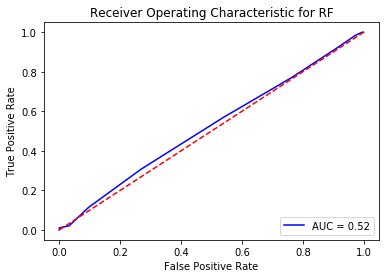

In [7]:
predModel(X_train, y_train, X_test, y_test, modelType='RF')

Accuracy for model XGB is: 0.51
ROC AUC for model XGB is: 0.50
Model training time is 12.191 seconds

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39       186
           1       0.51      0.68      0.58       192

    accuracy                           0.51       378
   macro avg       0.50      0.50      0.49       378
weighted avg       0.50      0.51      0.49       378


Confusion matrix:
[[ 60 126]
 [ 61 131]]


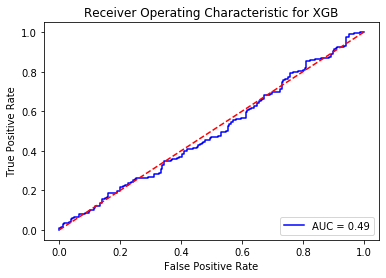

In [8]:
predModel(X_train, y_train, X_test, y_test, modelType='XGB')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy for model LogReg is: 0.46
ROC AUC for model LogReg is: 0.46
Model training time is 0.100 seconds

Classification report:
              precision    recall  f1-score   support

           0       0.44      0.37      0.40       186
           1       0.47      0.55      0.51       192

    accuracy                           0.46       378
   macro avg       0.45      0.46      0.45       378
weighted avg       0.46      0.46      0.45       378


Confusion matrix:
[[ 68 118]
 [ 87 105]]


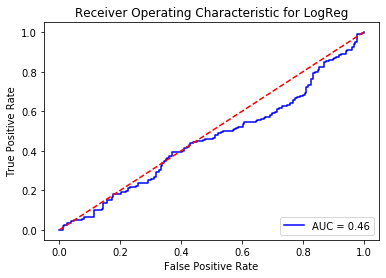

In [9]:
predModel(X_train, y_train, X_test, y_test, modelType='LogReg')

Accuracy for model SVC is: 0.51
ROC AUC for model SVC is: 0.50
Model training time is 5.062 seconds

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378


Confusion matrix:
[[  0 186]
 [  0 192]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


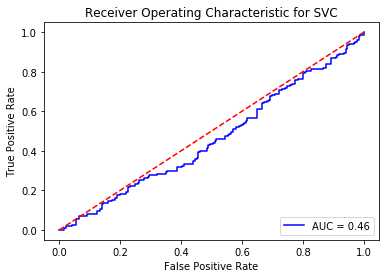

In [10]:
predModel(X_train, y_train, X_test, y_test, modelType='SVC')

Accuracy for model MLP is: 0.48
ROC AUC for model MLP is: 0.47
Model training time is 0.413 seconds

Classification report:
              precision    recall  f1-score   support

           0       0.42      0.18      0.25       186
           1       0.49      0.77      0.60       192

    accuracy                           0.48       378
   macro avg       0.46      0.47      0.42       378
weighted avg       0.46      0.48      0.43       378


Confusion matrix:
[[ 33 153]
 [ 45 147]]


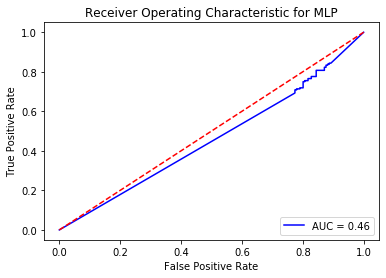

In [11]:
predModel(X_train, y_train, X_test, y_test, modelType='MLP')